# <center> Descriptive Analysis from Jérémy </center>

Chargement des bibliothèques

In [1]:
library(data.table)
library(stringr) # manipulation de chaine de caracteres
library(ggplot2)
library(corrplot)  # affichage matrice des correlations
library(questionr) # pour le calcul du Vcramer
library(FactoMineR) # analyses factorielles  
library(factoextra) # representation sympa analyses factorielles
library(Hmisc)
library(missMDA) # imputation des donnÃ©es manquantes
library(fastcluster)
library(fpc) # pour appeler dbscan
library(dbscan) # pour appeler hdbscan

Warning message:
"package 'corrplot' was built under R version 3.4.3"corrplot 0.84 loaded
Warning message:
"package 'questionr' was built under R version 3.4.3"Warning message:
"package 'factoextra' was built under R version 3.4.3"Welcome! Related Books: `Practical Guide To Cluster Analysis in R` at https://goo.gl/13EFCZ
Warning message:
"package 'Hmisc' was built under R version 3.4.3"Loading required package: lattice
Loading required package: survival
Loading required package: Formula

Attaching package: 'Hmisc'

The following objects are masked from 'package:questionr':

    describe, wtd.mean, wtd.table, wtd.var

The following objects are masked from 'package:base':

    format.pval, units

Warning message:
"package 'missMDA' was built under R version 3.4.3"
Attaching package: 'fastcluster'

The following object is masked from 'package:stats':

    hclust

Warning message:
"package 'dbscan' was built under R version 3.4.3"
Attaching package: 'dbscan'

The following object is masked

## 1. Import des données

In [6]:
setwd("D:/Dropbox/Data science/Formation CEPE/Projet/GitHub/SiWIM-project")
don <- read.table("2_Data/2_Retraitees/SiWIM_data_prepared.csv",sep = ",",header = TRUE)
don <- data.table(don)

## 2. Préparation des données

On retire certaines variables inutiles car converties en d'autres plus utiles

In [7]:
don [, c("v","WGV", "W1","W2","W3","W4","W5","W6","W7","W8","W9","W10",
          "W11","W12","W13","W14","W15","W16") := NULL]

Creation de variables date et d'horaire

In [8]:
don[, Annee := format(as.Date(don$Date), format = "%Y")]
don[, Mois1 := format(as.Date(don$Date), format = "%m")]
don[, Mois2 := format(as.Date(don$Date), format = "%B")]
don[, Jour1 := format(as.Date(don$Date), format = "%d")]
don[, Jour2 := format(as.Date(don$Date), format = "%A")]
don[, Heure := str_sub(Horaire, 1, 2)]

Création du champs Anomalie (1 : présence Anomalie, 0 : absence Anomalie)<br/>
[idee] Peut-on separer ce qui est une anomalie de relever (bruit) d'une anomalie du poids lourd (ex : surchargé)

In [9]:
#don[Warning_flags != "00000000",Anomalie := 1]
don[,Anomalie := 0][Warning_flags != "00000000",Anomalie := 1]

On convertit en factor "Subclass_ID" et "Axle_groups", "Mois2, "Jour2" et "Heure"

In [10]:
don[, Subclass_ID := factor(don$Subclass_ID)]
don[, Axle_groups := factor(don$Axle_groups)]
don[, Mois2 := factor(don$Mois2)]
don[, Jour2 := factor(don$Jour2)]
don[, Heure := factor(don$Heure)]
don[, Anomalie := factor(don$Anomalie)]

On cree deux jeux de donnees contenant var qualitatives et quantitatives pour les futurs traitements

In [11]:
varquali <- don[,c("X","Timestamp","Horaire","Annee","Mois1","Mois2","Jour1","Jour2","Heure","Site_ID","Warning_flags","Lane","Subclass_ID",
                    "Axle_groups","Date","Anomalie")]

varquanti <- don[,names(varquali)[-1] := NULL]


## 3. Analyse descriptive

Vue d'ensemble des données

In [12]:
summary(varquali)

       X                        Timestamp          Horaire      
 Min.   :     1   2017-07-25 09:54:28:     3   14:35:31:    14  
 1st Qu.: 45983   2017-07-28 09:19:52:     3   07:50:09:    13  
 Median : 91965   2017-08-22 11:50:07:     3   14:57:30:    13  
 Mean   : 91965   2017-08-23 13:24:52:     3   08:05:55:    12  
 3rd Qu.:137946   2017-09-25 08:06:38:     3   08:19:22:    12  
 Max.   :183928   2017-10-03 09:17:58:     3   10:12:06:    12  
                  (Other)            :183910   (Other) :183852  
    Annee              Mois1                 Mois2          Jour1          
 Length:183928      Length:183928      août     :40498   Length:183928     
 Class :character   Class :character   juillet  :42860   Class :character  
 Mode  :character   Mode  :character   novembre :36439   Mode  :character  
                                       octobre  :32006                     
                                       septembre:32125                     
                        

In [10]:
summary(varquanti)

       X                N          total_axle_dist         A1         
 Min.   :     1   Min.   : 2.000   Min.   : 0.9032   Min.   : 0.3191  
 1st Qu.: 45983   1st Qu.: 4.000   1st Qu.: 9.2666   1st Qu.: 3.7209  
 Median : 91965   Median : 5.000   Median :12.1818   Median : 3.8425  
 Mean   : 91965   Mean   : 4.357   Mean   :11.2357   Mean   : 4.0128  
 3rd Qu.:137946   3rd Qu.: 5.000   3rd Qu.:12.4545   3rd Qu.: 3.9704  
 Max.   :183928   Max.   :16.000   Max.   :80.8727   Max.   :19.8194  
                                                                      
       A2              A3              A4              A5        
 Min.   : 0.33   Min.   : 0.35   Min.   : 0.33   Min.   : 0.32   
 1st Qu.: 5.05   1st Qu.: 1.32   1st Qu.: 1.30   1st Qu.: 1.34   
 Median : 5.78   Median : 1.35   Median : 1.34   Median : 1.92   
 Mean   : 5.34   Mean   : 1.76   Mean   : 1.55   Mean   : 3.29   
 3rd Qu.: 6.03   3rd Qu.: 1.41   3rd Qu.: 1.38   3rd Qu.: 4.72   
 Max.   :18.88   Max.   :19.50   Max


De nombreuses données manquantes sont présentes sur les variables A1 à  A16 représentant les distances entre essieux <br/>
Si pas d'essieux, alors les variables Ai prennent comme valeur "NA". A voir si il est nécessaire d'imputer la valeur "0" <br/>
Idem pour le poids de chaque camion. Les variables Mi comportent de nombreuses données manquantes, car il n'y a pas d'essieu correspondant et donc de poids associé. <br/>
A voir si on impute la valeur "0" pour les "NA"


9 valeurs manquantes sur les groupes d'essieux <br/>
Conclusion : la qualité du jeu de donnée est bonne du point de vue des valeurs manquantes

## 4. Analyse unidimensionnelle : variable qualitative

* Mois de circulation

In [13]:
freq(varquali$Mois2, sort = "dec")

,n,%,val%
juillet,42860,23.3,23.3
août,40498,22.0,22.0
novembre,36439,19.8,19.8
septembre,32125,17.5,17.5
octobre,32006,17.4,17.4


On note un léger pic l'été

+ Jour de circulation

In [14]:
freq(varquali$Jour2, sort = "dec")

,n,%,val%
mercredi,39287,21.4,21.4
jeudi,38343,20.8,20.8
mardi,35025,19.0,19.0
lundi,32477,17.7,17.7
vendredi,30005,16.3,16.3
samedi,5359,2.9,2.9
dimanche,3432,1.9,1.9


Les jours de circulation sont équilibrés (hors Samedi et Dimanche). <br/> 
On constate quelques circulations les Samedi et Dimanche : légal ?


+ Heure de circulation

In [15]:
freq(varquali$Heure, sort = "dec")

,n,%,val%
15,14555,7.9,7.9
14,14432,7.8,7.8
10,13402,7.3,7.3
09,13172,7.2,7.2
16,13096,7.1,7.1
13,13069,7.1,7.1
07,12753,6.9,6.9
08,12677,6.9,6.9
11,12647,6.9,6.9
12,12551,6.8,6.8


Les camions semblent moins circuler de 20h à 5h (donc la nuit) qu'en journée

+ Voie

,n,%,val%
droite,167810,91.2,91.2
gauche,16118,8.8,8.8


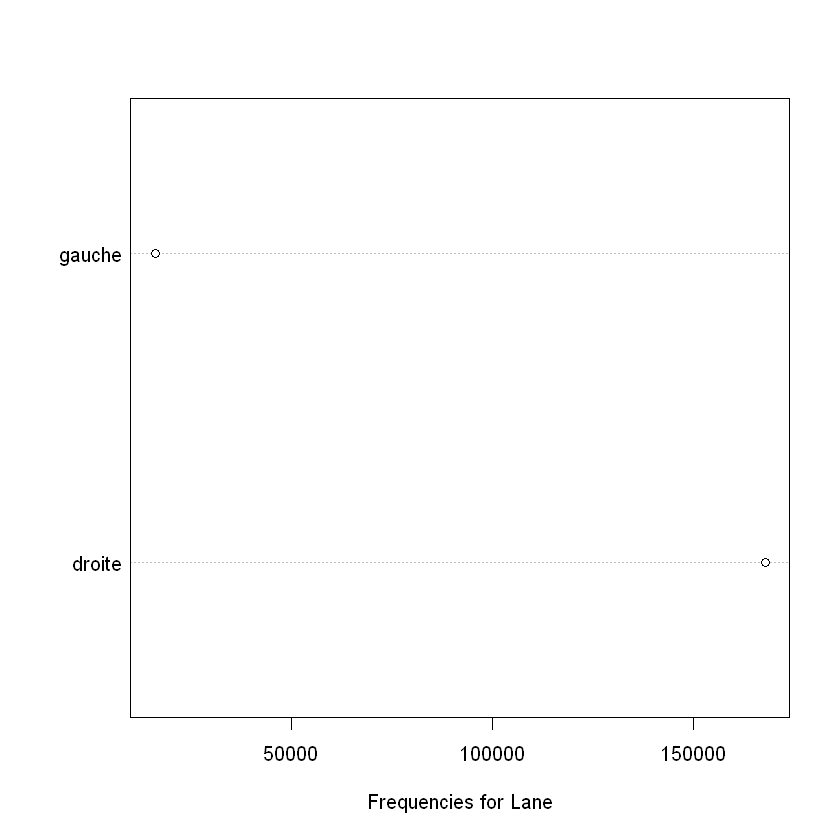

In [16]:
hist.data.frame(varquali[,"Lane"]) 
freq(varquali$Lane)

Lors de la capture des données, 91% des camions ont roulé à droite. <br/>
Les 9% ayant roulé à gauche étaient-t-ils en dépassement de vitesse ?



+ Warning flags

In [17]:
freq(varquali$Warning_flags,sort = "dec")

,n,%,val%
00000000,130647,71.0,71.0
00008000,10159,5.5,5.5
00800000,10033,5.5,5.5
00000001,10018,5.4,5.4
00000080,9102,4.9,4.9
00000081,4572,2.5,2.5
00000200,4460,2.4,2.4
00000800,984,0.5,0.5
00800001,950,0.5,0.5
00000201,719,0.4,0.4


71% n'ont pas donné lieu à une anomalie (warning flags), il y a donc eu 29 % d'anomalie

+ Analyse de la répartition des anomalies relevées par le système (on exclue "00000000")

In [18]:
freq(varquali$Warning_flags, exclude = c("00000000"), sort = "dec")

,n,%,val%
00008000,10159,19.1,19.1
00800000,10033,18.8,18.8
00000001,10018,18.8,18.8
00000080,9102,17.1,17.1
00000081,4572,8.6,8.6
00000200,4460,8.4,8.4
00000800,984,1.8,1.8
00800001,950,1.8,1.8
00000201,719,1.3,1.3
00008001,653,1.2,1.2


Les anomalies les plus fréquentes sont donc : <br/>
* 00008000 : vehicle reconstructed
+ 00800000 : vehicle overloaded
+ 00000001 : multiple truck presence
+ 00000080 : negative axle loads or WGV
+ 00000081 : ?
+ 00000200 : vehicle reclassified


+ Subclass_ID (classification réalisée par le système de pesage)

In [19]:
freq(varquali$Subclass_ID, sort = "dec")

,n,%,val%
113,72716,39.5,39.5
61,19835,10.8,10.8
74,15576,8.5,8.5
40,11317,6.2,6.2
140,10661,5.8,5.8
41,9320,5.1,5.1
30,6698,3.6,3.6
103,4137,2.2,2.2
110,3222,1.8,1.8
100,3117,1.7,1.7


Les deux classifications les plus fréquentes réalisées par le systèmes sont 113 et 61 (50% à elles deux)

+ Groupe d'essieux (constatés)

In [20]:
freq(varquali$Axle_groups, sort = "dec")

,n,%,val%
113,94326,51.3,51.3
11,31004,16.9,16.9
112,24591,13.4,13.4
111,5368,2.9,2.9
12,4826,2.6,2.6
122,4045,2.2,2.2
1111,2681,1.5,1.5
2,1319,0.7,0.7
1211,1266,0.7,0.7
1121,1122,0.6,0.6


Seul 113 ressort comme sur la classification réalisée par le système

[Idée] : il pourrait etre intéressant de considérer comme un label (Y) le groupe d'essieux, et 
de réaliser une classification en la comparant à celle réalisée pour le système (Subclass Id)
à titre de comparaison  

[A FAIRE] création d'une variable anomalie (binaire 0 = pas d'anomalie, 1 = anomalie) <br/>
regrouper éventuellement les anomalies

## 5. Analyse unidimensionnelle : variable quantitative

+ Nombre d'essieux

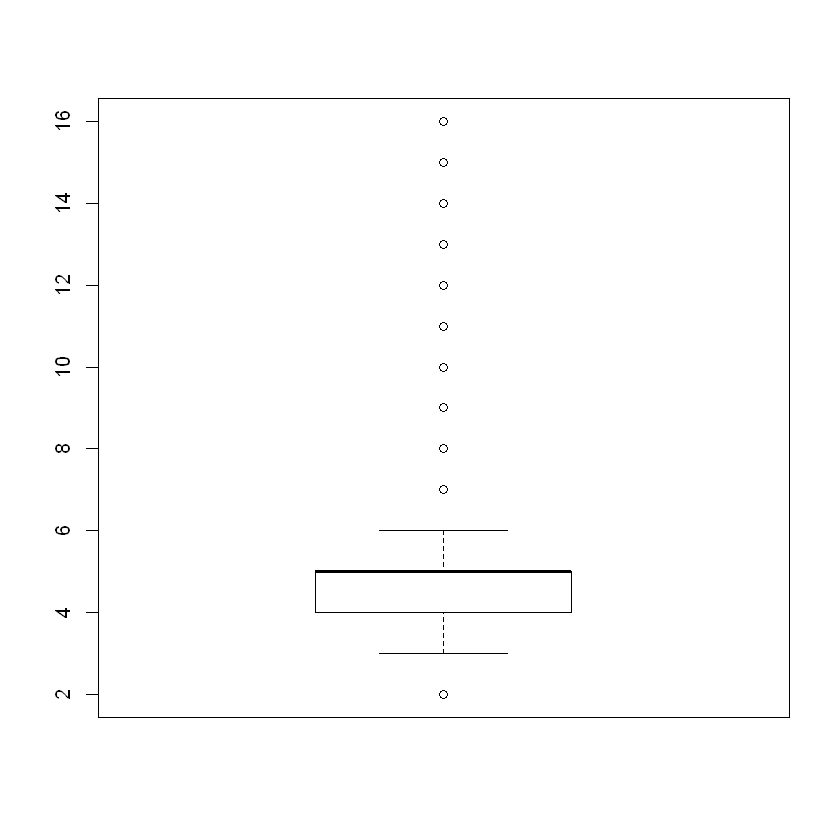

In [21]:
boxplot(varquanti$N)

camions à 16 essieux == individus aberrants ?

+ total_axle_dist (donne par approximation la longueur du camion)

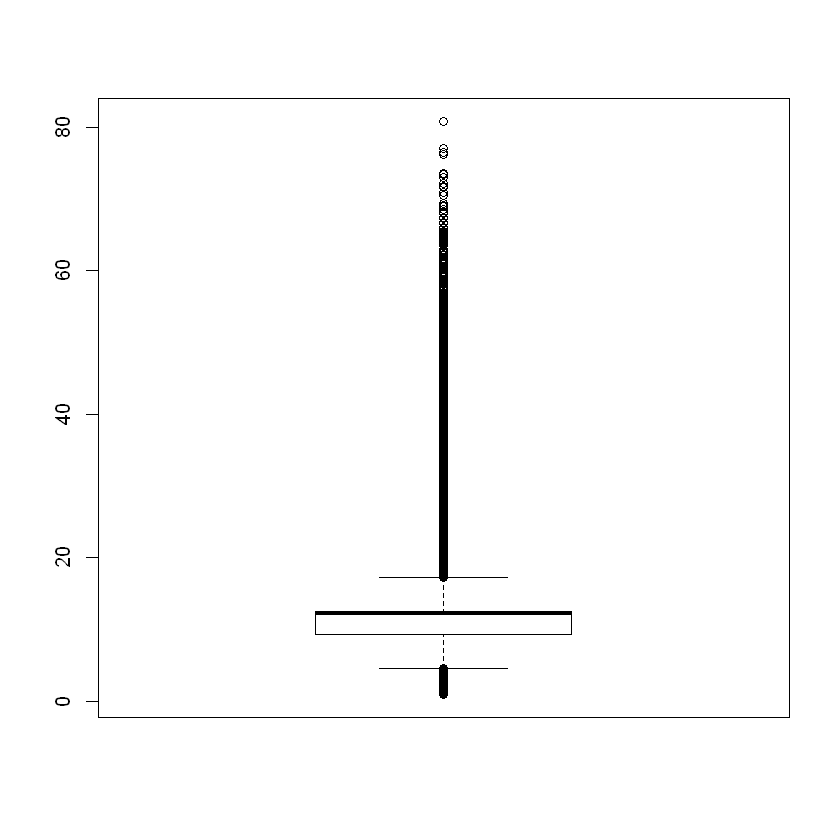

In [22]:
boxplot(varquanti$total_axle_dist)

La mediane est à 12m, ce qui représente la longueur maximum d'un véhicule isolé

+ Temperature utilisée par la compensation

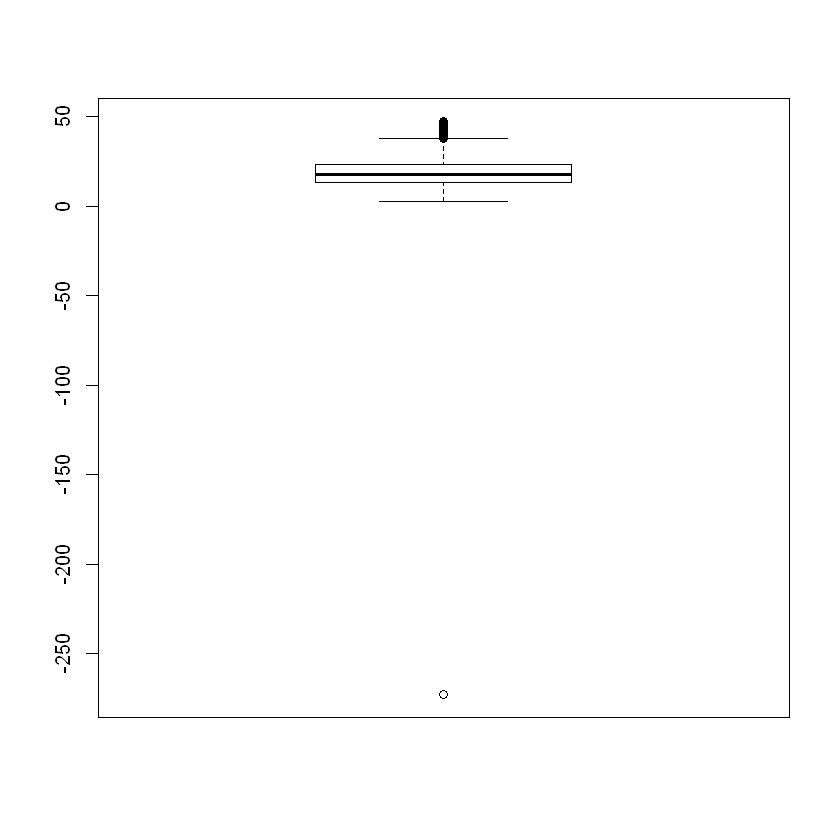

In [23]:
boxplot(varquanti$T) 

Il y a clairement des valeurs aberrantes (température de -273°C)

+ Nombre de valeurs abérrantes dans la Température 

[1] 2014

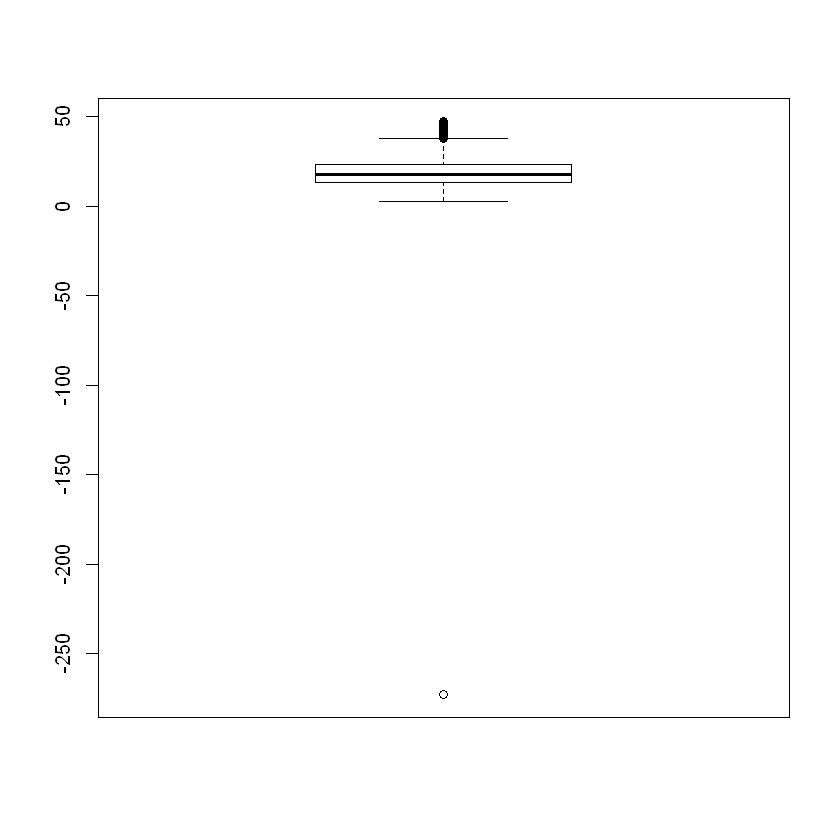

In [24]:
T <- sort(boxplot(varquanti$T)$out)
length(which (varquanti$T == -273))

2014 valeurs de -273°C ! <br/> 
L'observation des indices semblent montrer une continuité dans la captation de cette valeur aberrante <br/>
[IDEE] imputer une valeur moyenne

+ Vitesse

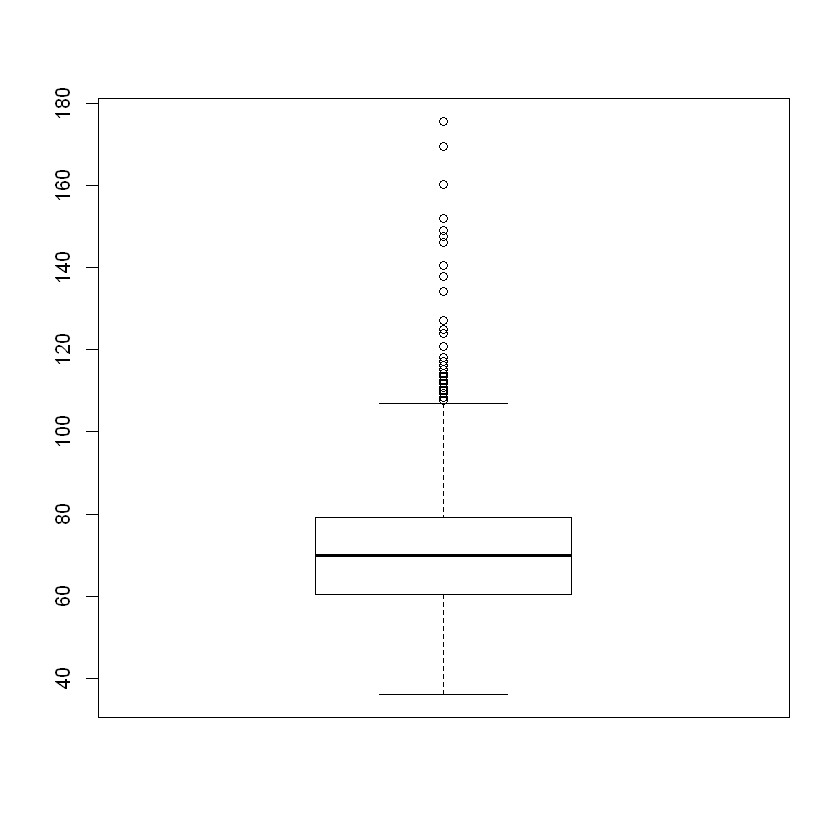

In [25]:
boxplot(varquanti$Vitesse)

Plusieurs vitesses apparaissent excessives (peut-on rouler à plus de 130 km/h avec un camion ?) <br/>
La vitesse mediane est autour de 70km/h

+ Masse du camion

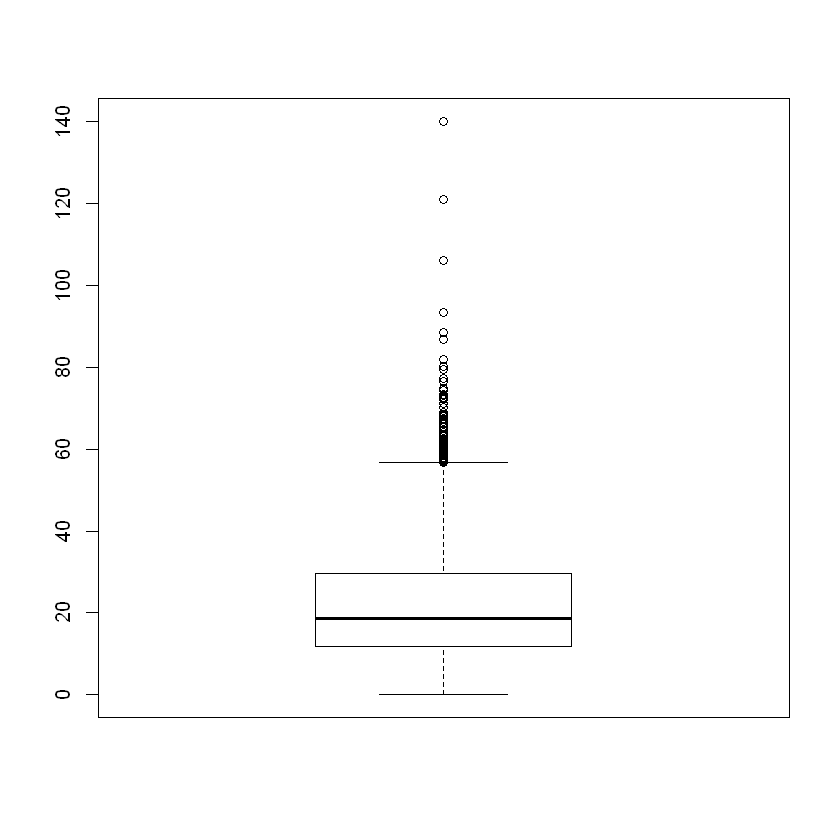

In [26]:
boxplot(varquanti$MGV)

Plusieurs valeurs semblent aberrantes. A partir de quelle masse considére-t-on la valeur comme anormale ? <br/>
Mediane à 19 tonnes

## 6. Analyse bi dimensionnelle (Etude des liaisons)

+ Croisement heure et jour de passage

          
             00   01   02   03   04   05   06   07   08   09   10   11   12
  dimanche   30   25   19   17   27   11   56   49   81  153  214  259  234
  jeudi     203  149  211  346  451  828 1673 2761 2714 2675 2753 2467 2463
  lundi      83  127  144  210  273  666 1136 2034 2252 2402 2537 2404 2379
  mardi     156  154  200  270  387  716 1459 2409 2302 2304 2474 2288 2273
  mercredi  179  196  246  345  440  896 1672 2662 2600 2779 2699 2694 2763
  samedi    124  122  143  235  243  257  273  350  323  374  382  334  345
  vendredi  188  168  222  313  444  860 1544 2488 2405 2485 2343 2201 2094
          
             13   14   15   16   17   18   19   20   21   22   23
  dimanche  252  304  247  240  308  275  193  182  115   76   65
  jeudi    2598 2992 3080 2943 2351 1801 1129  764  492  315  184
  lundi    2404 2706 2646 2351 1821 1380  982  597  446  277  220
  mardi    2480 2804 2839 2711 2389 1701 1144  667  395  311  192
  mercredi 2800 3123 3234 2864 2497 1744

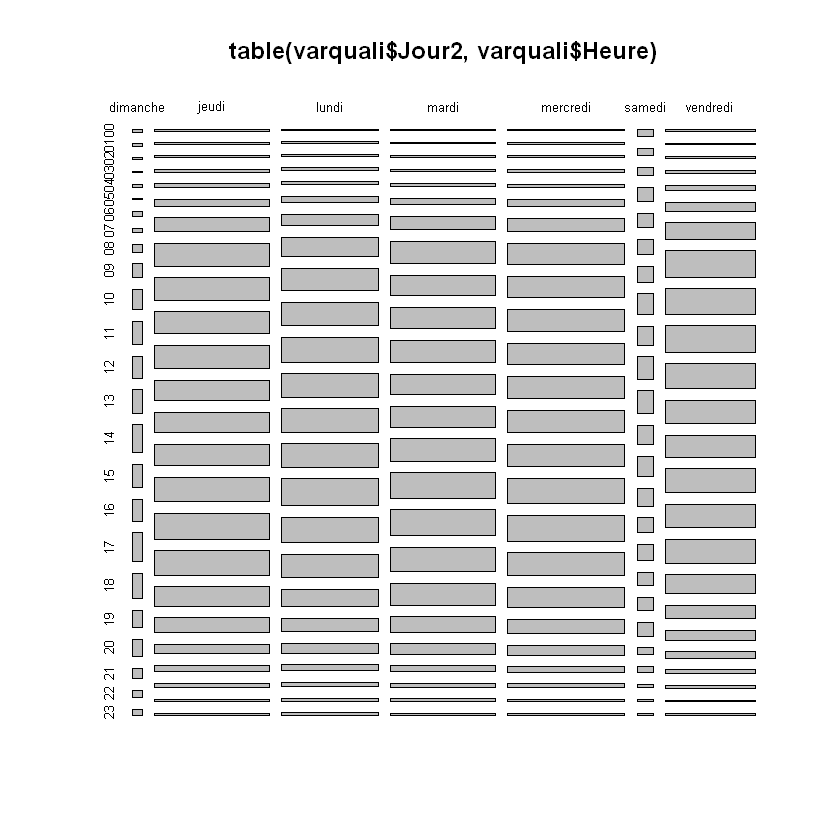

In [27]:
table(varquali$Jour2,varquali$Heure)
plot(table(varquali$Jour2,varquali$Heure))

En résumé : les camions circulent peu samedi et dimanche et nettement moins de nuit

+ liaisons entre variables qualitatives (calcul du V de Cramer)

Warning message in stats::chisq.test(tab, correct = FALSE):
"Chi-squared approximation may be incorrect"Warning message in stats::chisq.test(tab, correct = FALSE):
"Chi-squared approximation may be incorrect"Warning message in stats::chisq.test(tab, correct = FALSE):
"Chi-squared approximation may be incorrect"Warning message in stats::chisq.test(tab, correct = FALSE):
"Chi-squared approximation may be incorrect"Warning message in stats::chisq.test(tab, correct = FALSE):
"Chi-squared approximation may be incorrect"Warning message in stats::chisq.test(tab, correct = FALSE):
"Chi-squared approximation may be incorrect"Warning message in stats::chisq.test(tab, correct = FALSE):
"Chi-squared approximation may be incorrect"Warning message in stats::chisq.test(tab, correct = FALSE):
"Chi-squared approximation may be incorrect"Warning message in stats::chisq.test(tab, correct = FALSE):
"Chi-squared approximation may be incorrect"Warning message in stats::chisq.test(tab, correct = FALSE):
"Chi

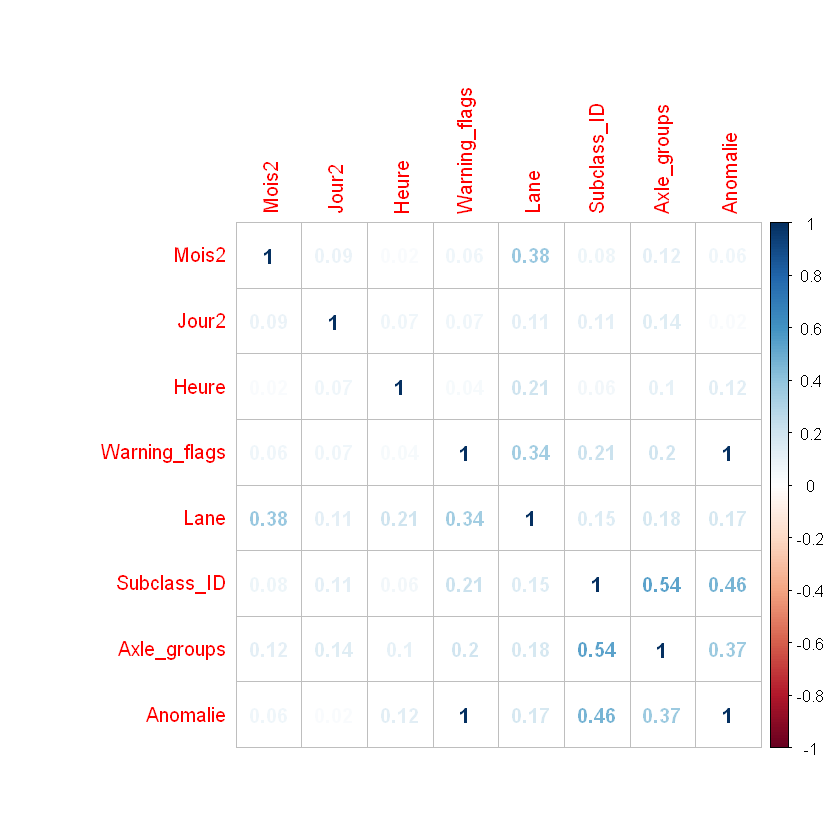

In [28]:
varquali2 <- varquali[,c("Mois2","Jour2","Heure","Warning_flags","Lane","Subclass_ID","Axle_groups","Anomalie")]
varquali2 <- as.data.frame(varquali2)
cramer <- matrix(NA, ncol(varquali2), ncol(varquali2))
for (i in (1:ncol(varquali2))){
  for (j in (1:ncol(varquali2))){
    cramer[i,j] <- cramer.v(table(varquali2[,i], varquali2[,j]))
  }
}
colnames(cramer) <- colnames(varquali2)
rownames(cramer) <- colnames(varquali2)

corrplot(cramer, method="number")

[Analyse] il semble y avoir un lien entre la voie (lane) et le mois de circulation. Attention car les données ont été récupérées sur 5 mois. <br/>
Même chose pour l'heure mais dans une moindre mesure. <br/>
Vcramer est important entre SubClasss_ID et Axle_Group ce qui parait logique. <br/>
Il semble également y avoir un lien entre l'anomalie (Warning flag et le fait de rouler à gauche ou à droite) <br/>
Anomalie est liée parfaitement avec Warning flag (ce qui etait attendu), et fortement avec "SubClass ID" et "Axle_Group".


### Liaisons entre variables quantitatives 

On se concentre sur les variables quanti utiles

In [29]:
varquanti2 <- varquanti[,c("X","N", "total_axle_dist","T","Reduced_chi_squared","Time_num","Vitesse","MGV")]

### Gestion des valeurs aberrantes

On travaille sur le tableau simplifié quantitatif <br/>
Idée générale : attribuer aux données aberrantes (dont nous sommes surs qu'elles soient fausses) une valeur "NA", 
puis reconstituer leur valeur grâce aux techniques d'imputation du package "missMDA"

On considère comme valeur anormale au dessus de 8 essieux (ici 2843 valeurs dans ce cas)

In [30]:
index_aberrant_N <- which(varquanti2[,"N"] > 8) 
varquanti2[index_aberrant_N,"N"] <- NA

In [31]:
# on considère comme valeur anormale une distance totale entre les axes supérieure à 20 m 
# (ici 5102 valeurs dans ce cas)
index_aberrant_total_axle_dist <- which(varquanti2[,"total_axle_dist"] > 20)
varquanti2[index_aberrant_total_axle_dist,"total_axle_dist"] <- NA

# on considère comme valeur anormale les températures négatives < à -10°C 
# (dans le jeu de données seule -273 est présente comme valeur négative, 2014 valeurs dans ce cas)
index_aberrant_T <- which(varquanti2[,"T"] < 0)
varquanti2[index_aberrant_T,"T"] <- NA

# on considère comme valeur anormale la vitesse d'un camion > 130 km/h (19 valeurs dans ce cas)
index_aberrant_Vitesse <- which(varquanti2[,"Vitesse"] > 130)
varquanti2[index_aberrant_Vitesse,"Vitesse"] <- NA

# on considère comme valeur anormale la masse d'un camion > 70 T (22 valeurs dans ce cas)
index_aberrant_MGV <- which(varquanti2[,"MGV"] > 70)
varquanti2[index_aberrant_MGV,"MGV"] <- NA

On cherche à présent à imputer les données manquantes en utilisant l'ACP <br/>
Recherche par validation croisée du nombre d'axes optimal pour l'ACP <br/>
On retire X qui est un index <br/>
Attention très long on peut utiliser l'option method.cv = "Kfold" si nécessaire

In [32]:
nb_axe_imput <- estim_ncpPCA(varquanti2[,-1])
plot(nb_axe_imput$criterion, type ="h"

$ncp
[1] 0

$criterion
        0         1         2         3         4         5 
 83663.42 103309.46 148264.24 197204.80  45195.07  81031.92

On retient 4 axes car cela minimise le critère MSEP (mean squared error of prediction)

Imputation des données manquantes par ACP, avec 4 axes <br/>
L'imputation se base sur les corrélations entre variables et les ressemblances entre individus <br/>
On utilise une version régularisée de l'algo pour éviter le surajustement

In [40]:
varquanti3 <- imputePCA(varquanti2,ncp = 4, method ="regularized")
varquanti3 <- as.data.frame(varquanti3$completeObs)

#### Boxplot des valeurs aberrantes

In [41]:
summary(varquanti2)

       X                N         total_axle_dist        T         
 Min.   :     1   Min.   :2.000   Min.   : 0.903   Min.   : 2.747  
 1st Qu.: 45983   1st Qu.:4.000   1st Qu.: 9.188   1st Qu.:13.700  
 Median : 91965   Median :5.000   Median :12.165   Median :17.777  
 Mean   : 91965   Mean   :4.241   Mean   :10.622   Mean   :19.153  
 3rd Qu.:137946   3rd Qu.:5.000   3rd Qu.:12.425   3rd Qu.:23.490  
 Max.   :183928   Max.   :8.000   Max.   :20.000   Max.   :47.568  
                  NA's   :2843    NA's   :5102     NA's   :2014    
 Reduced_chi_squared    Time_num         Vitesse            MGV       
 Min.   :    0.0     Min.   :0.5138   Min.   : 36.05   Min.   : 0.00  
 1st Qu.:  100.0     1st Qu.:0.5929   1st Qu.: 60.43   1st Qu.:11.72  
 Median :  250.6     Median :0.6908   Median : 69.88   Median :18.56  
 Mean   :  475.5     Mean   :0.7071   Mean   : 70.11   Mean   :19.72  
 3rd Qu.:  524.5     3rd Qu.:0.8274   3rd Qu.: 79.28   3rd Qu.:29.72  
 Max.   :29201.3     Max.   :0

In [42]:
summary(varquanti3) # les variables ont été imputées

       X                N         total_axle_dist         T         
 Min.   :     1   Min.   :1.980   Min.   : 0.9032   Min.   : 2.747  
 1st Qu.: 45983   1st Qu.:4.000   1st Qu.: 9.1173   1st Qu.:13.752  
 Median : 91965   Median :5.000   Median :12.1618   Median :17.845  
 Mean   : 91965   Mean   :4.226   Mean   :10.6306   Mean   :19.256  
 3rd Qu.:137946   3rd Qu.:5.000   3rd Qu.:12.4308   3rd Qu.:23.732  
 Max.   :183928   Max.   :8.854   Max.   :24.6330   Max.   :47.568  
 Reduced_chi_squared    Time_num         Vitesse            MGV       
 Min.   :    0.0     Min.   :0.5138   Min.   : 36.05   Min.   : 0.00  
 1st Qu.:  100.0     1st Qu.:0.5929   1st Qu.: 60.43   1st Qu.:11.73  
 Median :  250.6     Median :0.6908   Median : 69.88   Median :18.57  
 Mean   :  475.5     Mean   :0.7071   Mean   : 70.12   Mean   :19.72  
 3rd Qu.:  524.5     3rd Qu.:0.8274   3rd Qu.: 79.28   3rd Qu.:29.73  
 Max.   :29201.3     Max.   :0.9078   Max.   :127.12   Max.   :68.99  

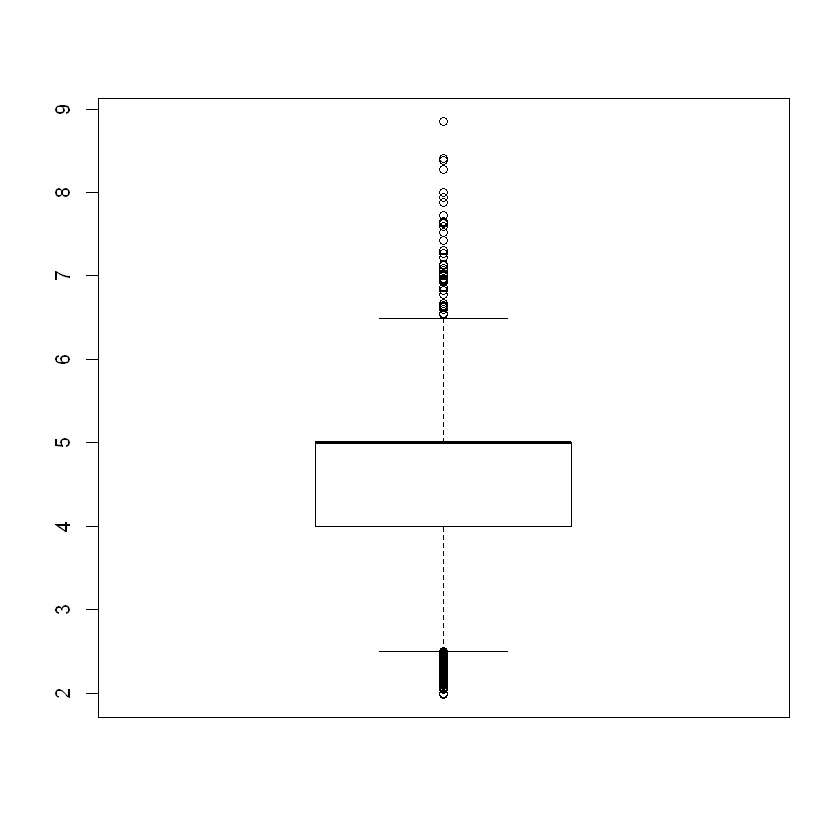

In [44]:
boxplot(varquanti3$N) 

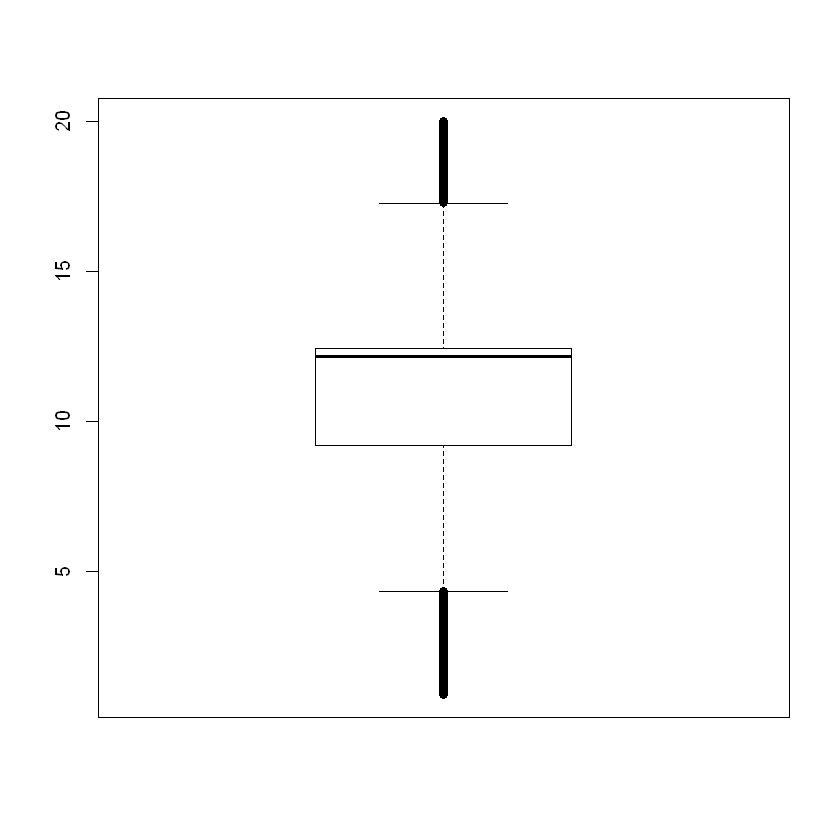

In [45]:
boxplot(varquanti2$total_axle_dist) 

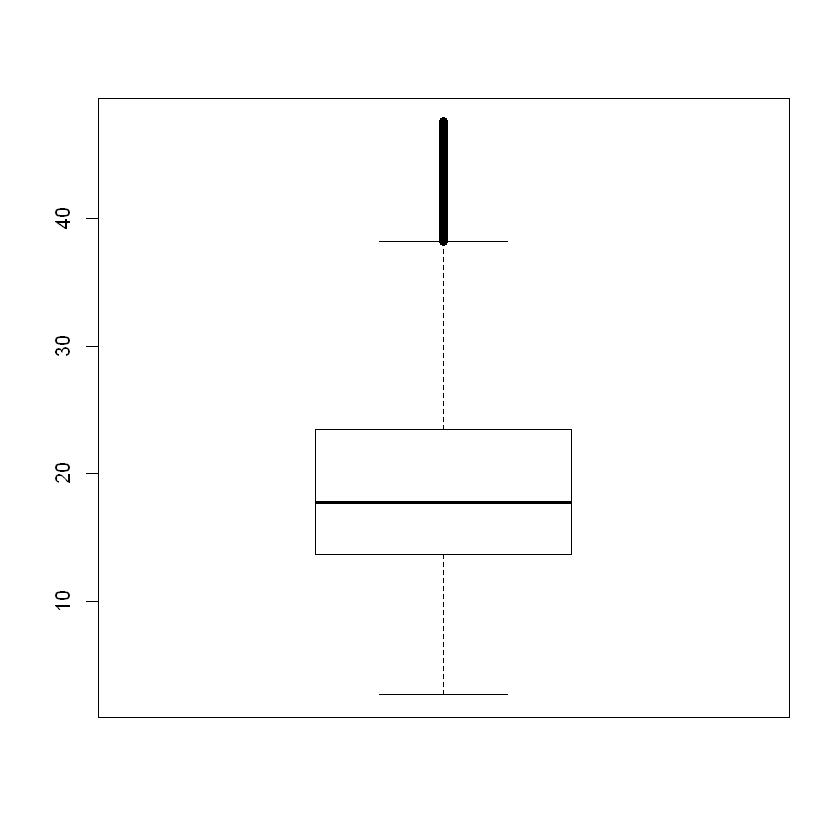

In [46]:
boxplot(varquanti2$T)

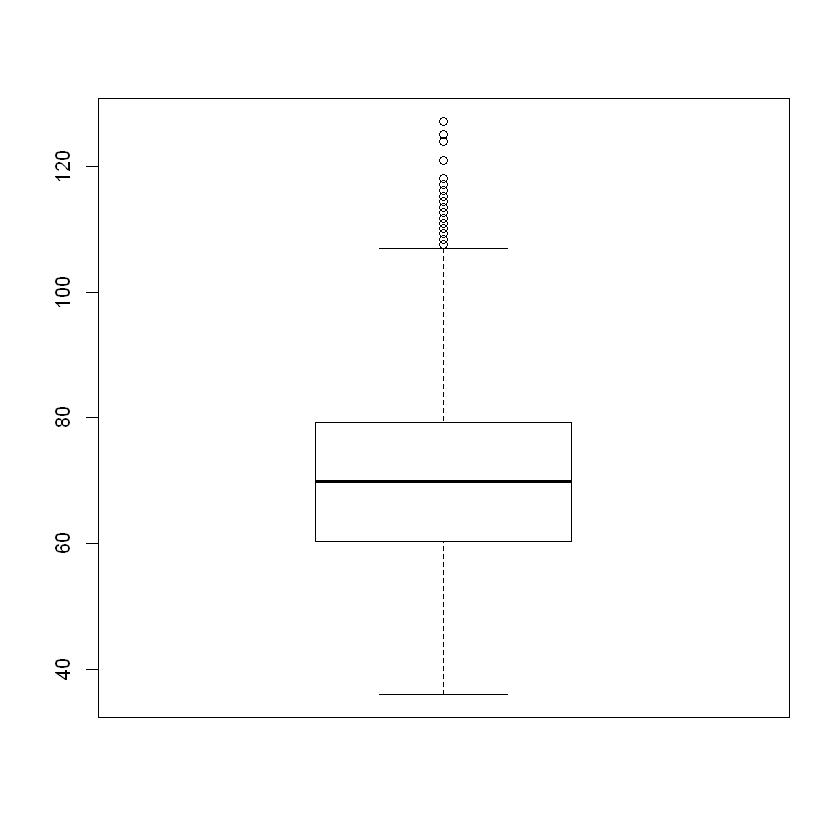

In [47]:
boxplot(varquanti2$Vitesse)

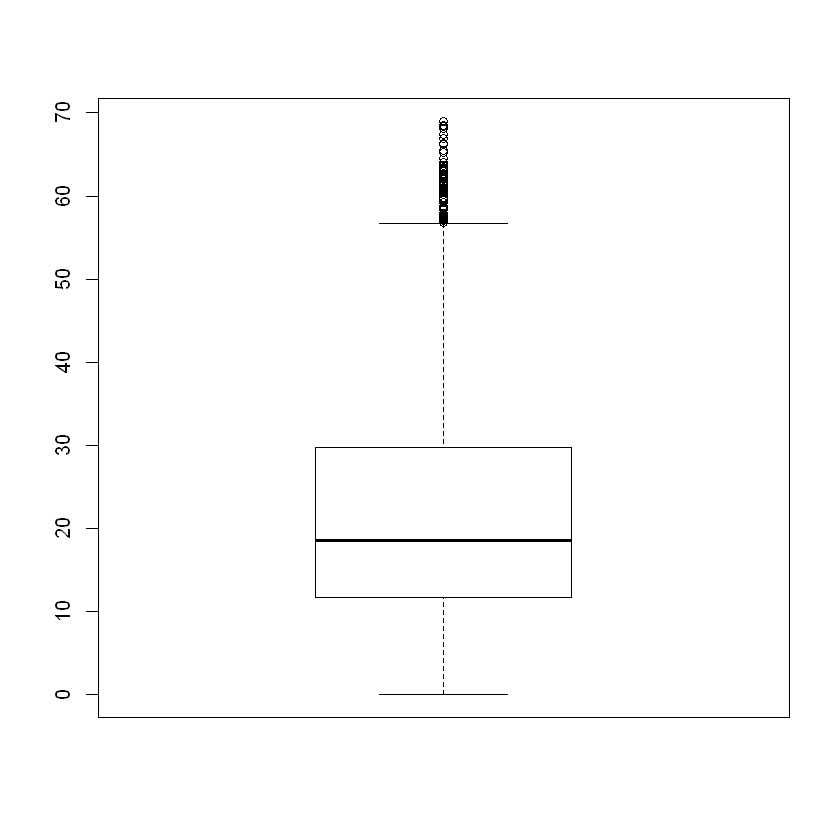

In [48]:
boxplot(varquanti2$MGV)

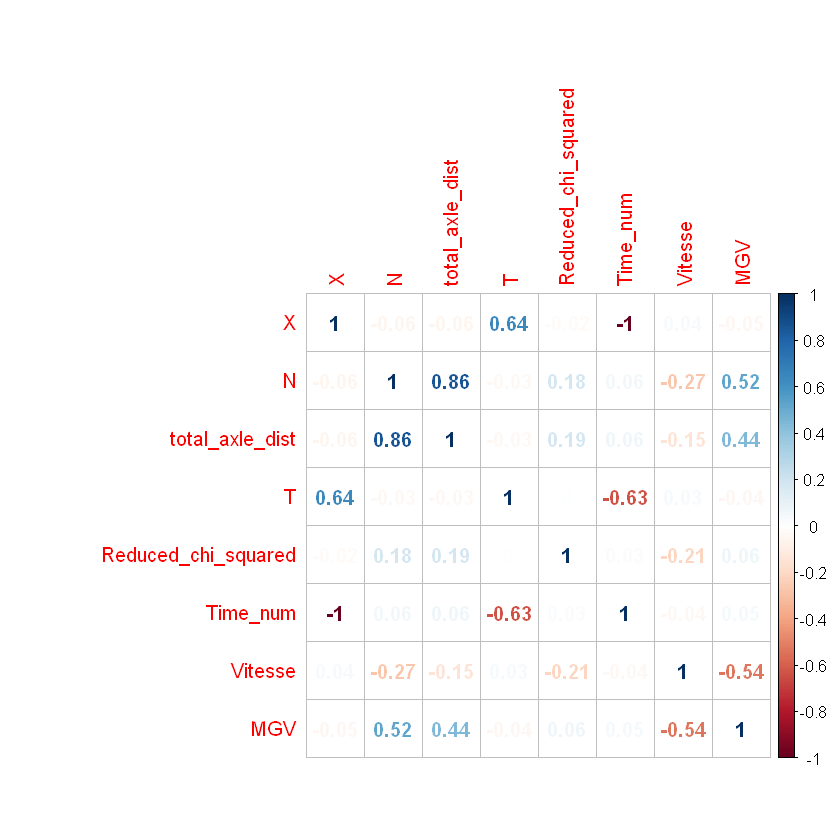

In [49]:
# (calcul du coefficient de corrélation de pearson)
corr <- cor(varquanti3)
corrplot(corr, method="number")

#### Analyse : <br/>
* La distance totale entre les essieux est corrélée linéairement au nombre d'essieux. <br/>
+ Une corréation négative, plutot forte, entre vitesse et masse (plus le poids lourd est massique, moins il va vite). <br/>
+ Une corrélation entre le nombre d'essieux et la masse du camion. <br/>
+ Une faible corrélation entre masse et nombre d'essieux et entre vitesse et nombre d'essieux (corrélation négative)



### Liaisons quanti / quali (anova / kruskall wallis)

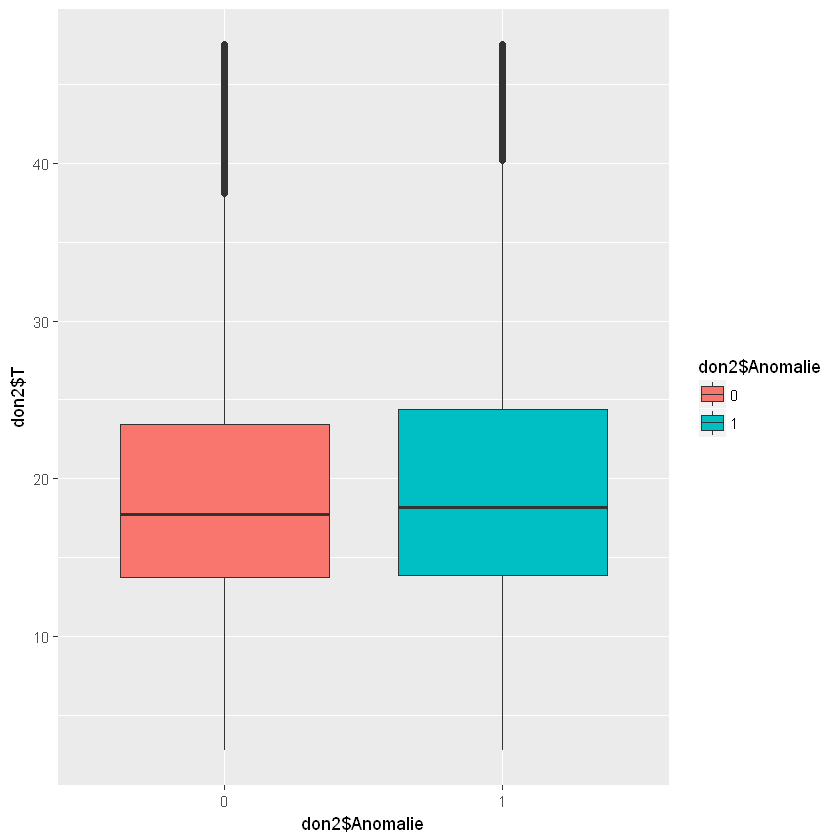

In [50]:
don2 = cbind(varquali2,varquanti3)
# Température / Ano
bp1 <- ggplot(don2, aes(don2$Anomalie, y=don2$T, group=don2$Anomalie)) + 
  geom_boxplot(aes(fill=don2$Anomalie))
bp1

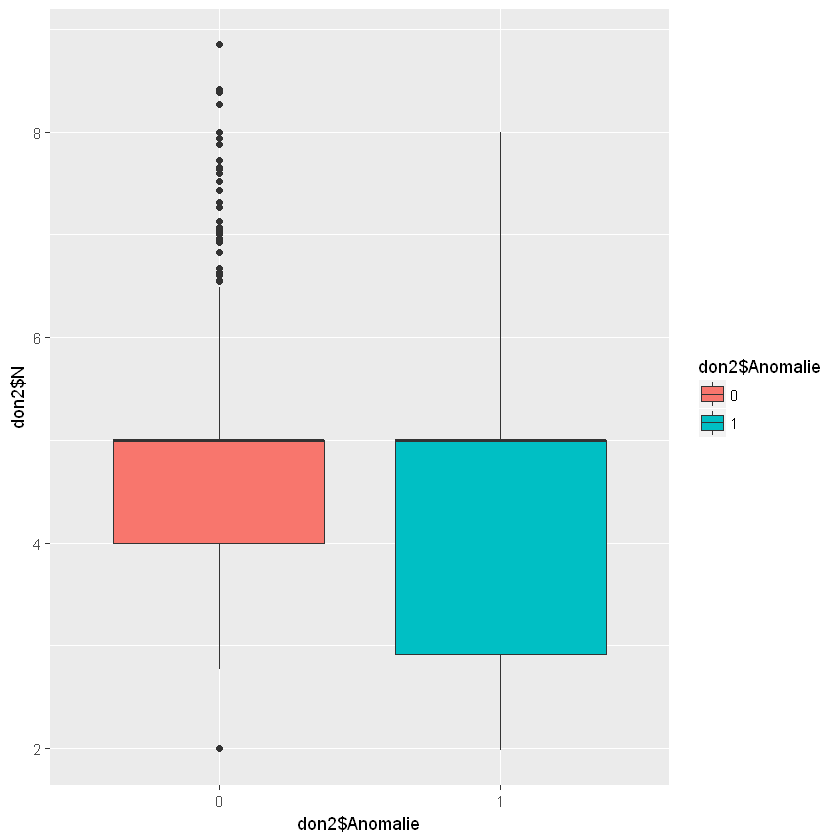

In [51]:
# Nb d'essieux / Ano
bp2 <- ggplot(don2, aes(don2$Anomalie, y=don2$N, group=don2$Anomalie)) + 
  geom_boxplot(aes(fill=don2$Anomalie))
bp2

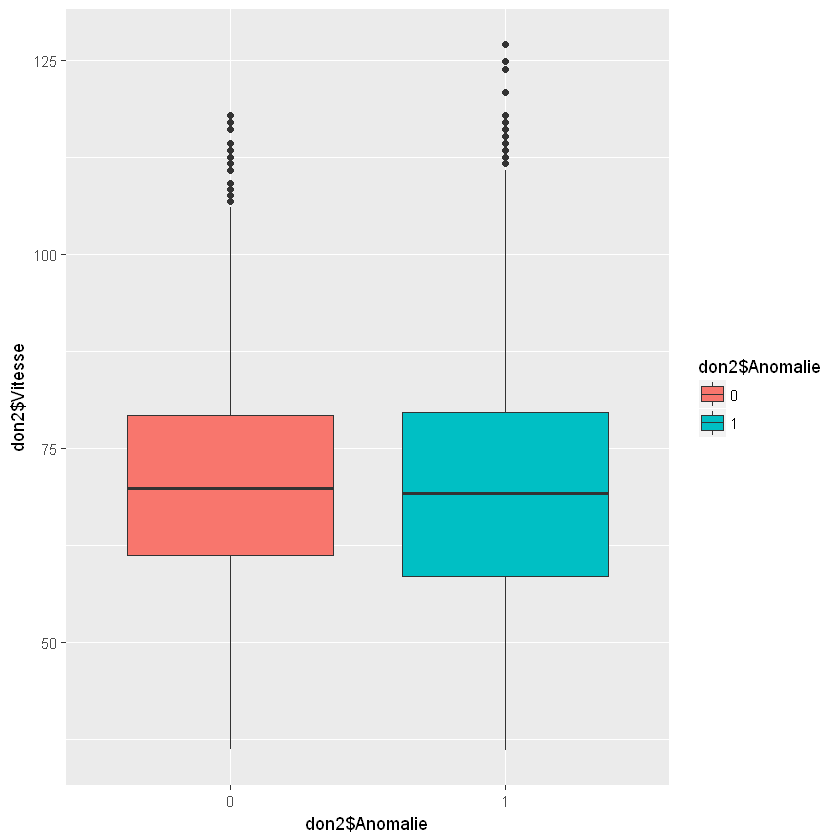

In [52]:
# Vitesse / Ano
bp3 <- ggplot(don2, aes(don2$Anomalie, y=don2$Vitesse, group=don2$Anomalie)) + 
  geom_boxplot(aes(fill=don2$Anomalie))
bp3

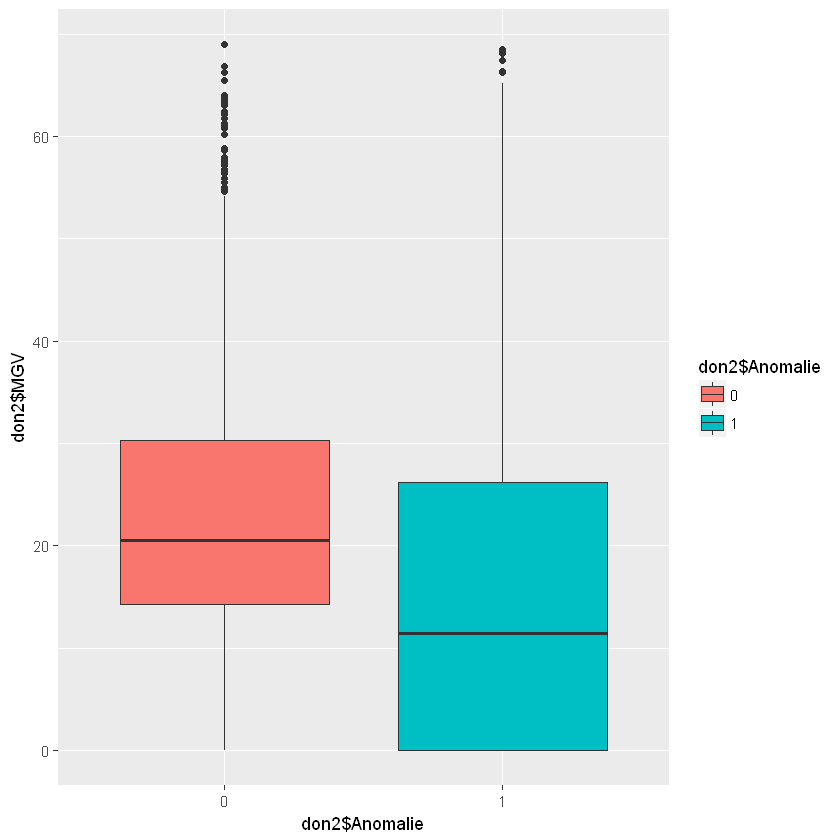

In [53]:
# Masse / Ano
bp4 <- ggplot(don2, aes(don2$Anomalie, y=don2$MGV, group=don2$Anomalie)) + 
  geom_boxplot(aes(fill=don2$Anomalie))
bp4

[Analyse] Les camions les plus lourds semblent subir moins d'anomalie.

## 7. Analyses Factorielles

In [54]:
# Analyse en composantes principales sur variables quantitatives en illustration (pour l'interprétation)
don_PCA <- cbind(varquanti3[,-1],varquali2$Lane, varquali2$Anomalie)
colnames(don_PCA)[c(8,9)] <- c("Lane","Anomalie")

res_pca <- PCA(don_PCA, scale.unit = TRUE, ncp = Inf, quali.sup = 8:9)
summary(res_pca)


Call:
PCA(X = don_PCA, scale.unit = TRUE, ncp = Inf, quali.sup = 8:9) 


Eigenvalues
                       Dim.1   Dim.2   Dim.3   Dim.4   Dim.5   Dim.6   Dim.7
Variance               2.519   1.616   1.051   0.955   0.366   0.358   0.133
% of var.             35.991  23.082  15.021  13.645   5.233   5.121   1.907
Cumulative % of var.  35.991  59.072  74.093  87.739  92.972  98.093 100.000

Individuals (the 10 first)
                        Dist    Dim.1    ctr   cos2    Dim.2    ctr   cos2  
1                   |  2.179 |  0.988  0.000  0.206 | -1.588  0.001  0.531 |
2                   |  3.532 | -2.633  0.001  0.556 | -2.102  0.001  0.354 |
3                   |  3.820 | -2.927  0.002  0.587 | -2.141  0.002  0.314 |
4                   |  2.208 |  0.562  0.000  0.065 | -1.640  0.001  0.551 |
5                   |  2.197 |  1.364  0.000  0.386 | -1.540  0.001  0.491 |
6                   |  2.079 |  0.868  0.000  0.174 | -1.614  0.001  0.603 |
7                   |  1.989 |  0.860  

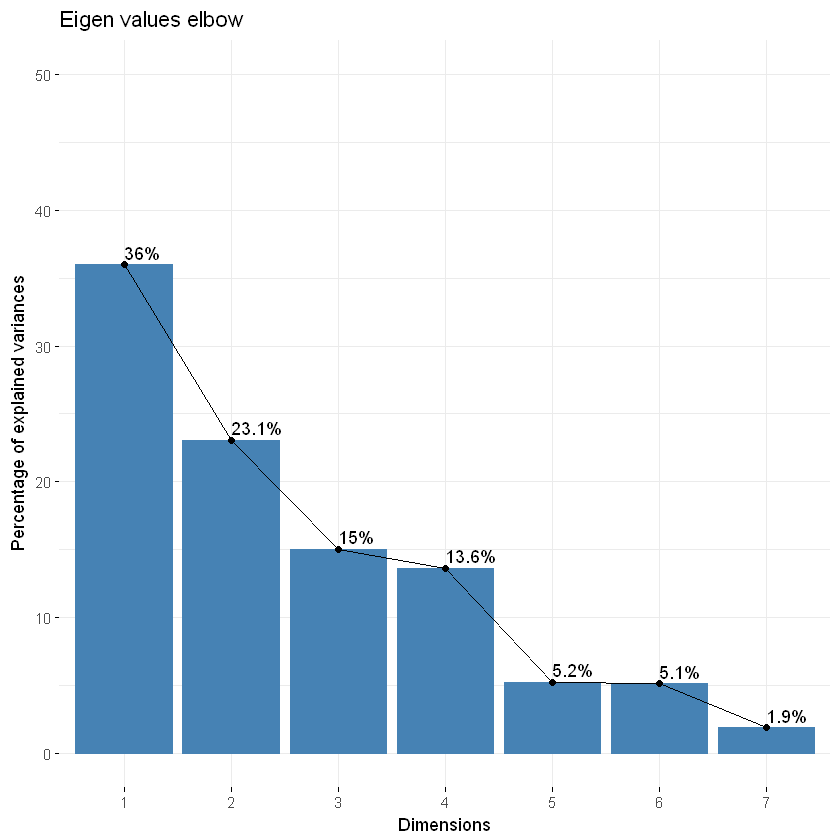

In [56]:
# Visualize eigenvalues/variances
fviz_screeplot(res_pca, addlabels = TRUE, ylim = c(0, 50), main ="Eigen values elbow")

Les 7 premières composantes principales capturent 100% de l'inertie <br/>
Les 4 premières 79% et les 5 premières 92%. Il sera intéressant par exemple de conserver 4 axes car ceux ci capturent l'essentiel de la variabilité et évitent d'utiliser 3 axes supplémentaires (couteux et les 13 d'inertie peuvent être assimilés à du bruit)

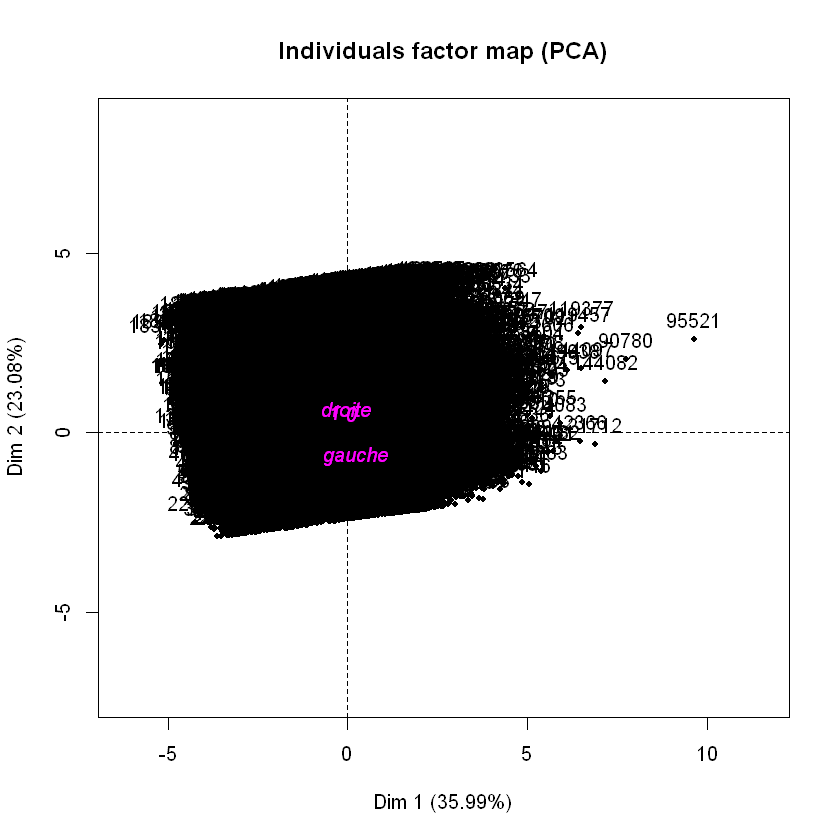

In [57]:
# affichage du nuage des individus
plot.PCA(res_pca)

il y a trop d'individus à afficher, difficile de voir des groupes se détacher

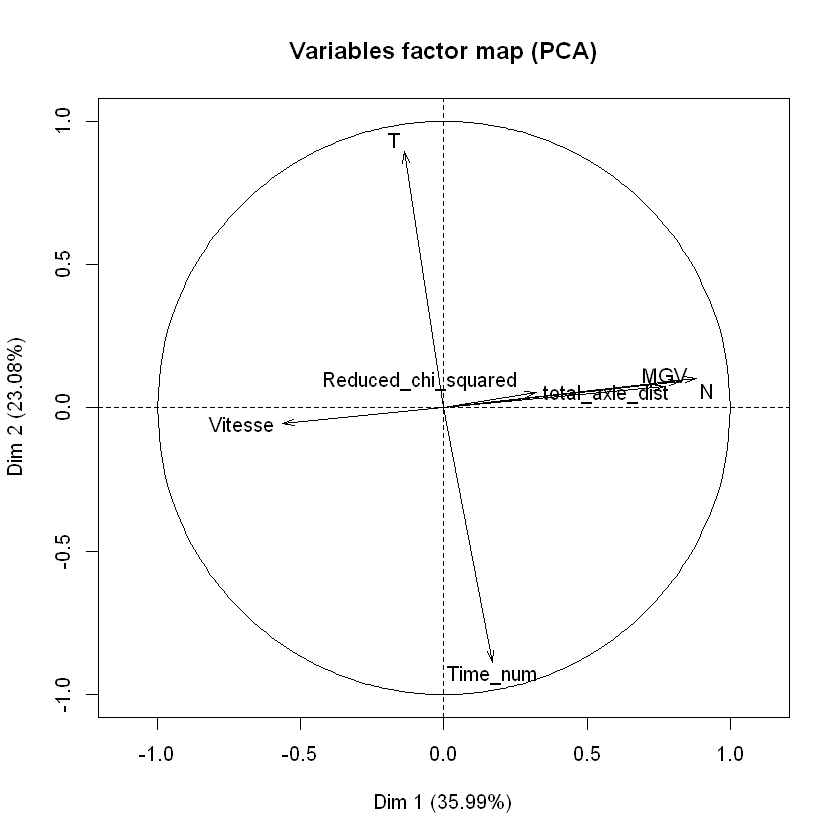

In [58]:
# affichage du cercle des corrélations sur le premier plan principal résumant environ 59% de l'information
plot(res_pca, choix = "var")

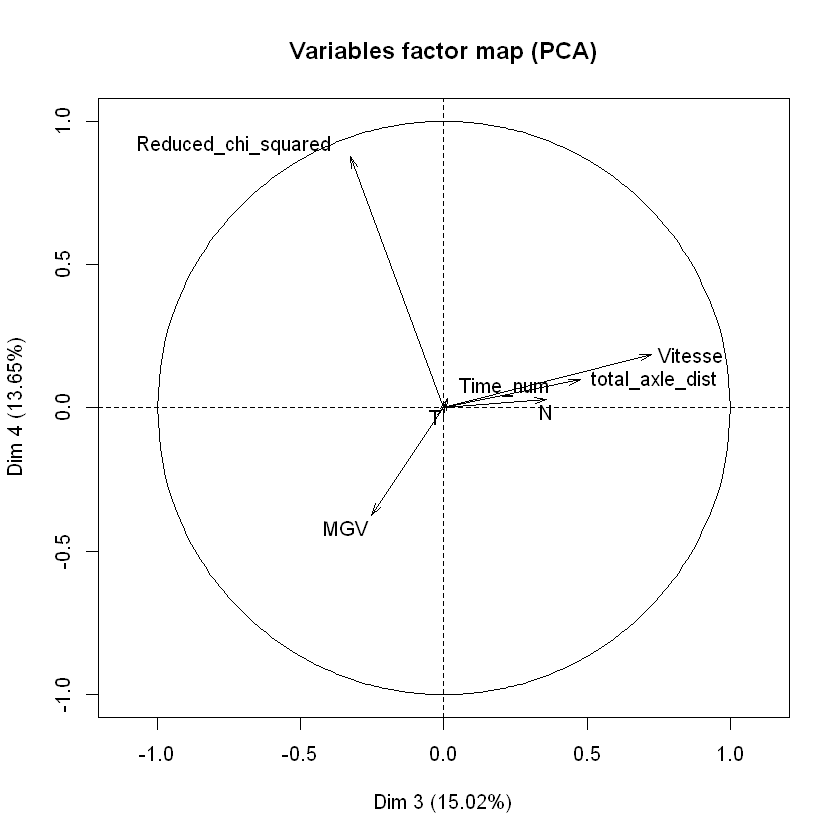

In [59]:
# affichage du plan des axes 3 et 4
plot(res_pca, choix = "var",axes = 3:4) 

In [60]:
# description automatique des dimensions (pour l'analyse)
dimdesc(res_pca)

,correlation,p.value
N,0.8804309,0
total_axle_dist,0.8262165,0
MGV,0.7691483,0
Reduced_chi_squared,0.3213161,0
Time_num,0.1698166,0
T,-0.1388937,0
Vitesse,-0.5644295,0
,R2,p.value
Anomalie,0.017917583,0.000000e+00
Lane,0.002439555,1.053212e-99


Interprétation du premier plan factoriel grâce au cercle des corrélations et à la description auto des dimensions, on observe des oppositions nettes :
* le premier axe oppose les camions les plus volumineux (car nombre d'essieux importants, masse importante, et longueur importante) au camion les plus petits, les moins lourds
+ Les camions les plus petits sont ceux qui vont le plus vite
+ le deuxième axe montre que la température est fortement corrélée négativeement à la variable Time_Num
Time_num est la variable numérique du temps : ici on montre que plus Time_num est importante, plus la température est basse.
Ce qui est logique car la prise de mesure s'est déroulée entre l'été et l'hiver !!!

Contribution des individus et des variables à la construction des axes factoriels :

+ on constate que les variables Nombre d'essieux, total_axle_dist et mgv contrbuent le plus (ctr) à la création de l'axe 1
* la vitesse contribue également bien dans une moindre mesure (2 fois moins)
pour l'axe 2, sa construction est quasi due aux deux variables T et Time_Num
* la qualité de représentation (le cos2) est très bonne pour N, total_axle_dist. Elle est bonne pour MGV. Vitesse n'a pas représentation excellente
sur l'axe 2, T et Time_Num sont plus très bien représentées

In [39]:
# Analyse des correspondances multiples (ACM) sur variables qualitatives
#res_mca <- MCA(varquali2[,c("Mois2","Jour2","Heure","Lane","Anomalie","Warning")])
#summary(res_mca)

[ATTENTION] : tres couteux en temps de calcul => reflechir à l'opportunité d'intégrer des variables qualitatives

In [40]:
# Analyse factorielle des données mixtes

## 8. Clustering

In [63]:
# On réalise un prétraitement par ACP
res_pca2 <- PCA(don_PCA[,1:7],ncp = 4, scale.unit = TRUE) # 
summary(res_pca2)


Call:
PCA(X = don_PCA[, 1:7], scale.unit = TRUE, ncp = 4) 


Eigenvalues
                       Dim.1   Dim.2   Dim.3   Dim.4   Dim.5   Dim.6   Dim.7
Variance               2.519   1.616   1.051   0.955   0.366   0.358   0.133
% of var.             35.991  23.082  15.021  13.645   5.233   5.121   1.907
Cumulative % of var.  35.991  59.072  74.093  87.739  92.972  98.093 100.000

Individuals (the 10 first)
                        Dist    Dim.1    ctr   cos2    Dim.2    ctr   cos2  
1                   |  2.179 |  0.988  0.000  0.206 | -1.588  0.001  0.531 |
2                   |  3.532 | -2.633  0.001  0.556 | -2.102  0.001  0.354 |
3                   |  3.820 | -2.927  0.002  0.587 | -2.141  0.002  0.314 |
4                   |  2.208 |  0.562  0.000  0.065 | -1.640  0.001  0.551 |
5                   |  2.197 |  1.364  0.000  0.386 | -1.540  0.001  0.491 |
6                   |  2.079 |  0.868  0.000  0.174 | -1.614  0.001  0.603 |
7                   |  1.989 |  0.860  0.000  0.187

on garde 4 dimensions sur les 7 représentant 87% de l'information

### DBScan

In [64]:
# dbscan
set.seed(123)
db <- dbscan::dbscan(res_pca2$ind$coord, eps = 0.2) # calcul beaucoup plus rapide mais ayant l'air de donner un résultat bizarre

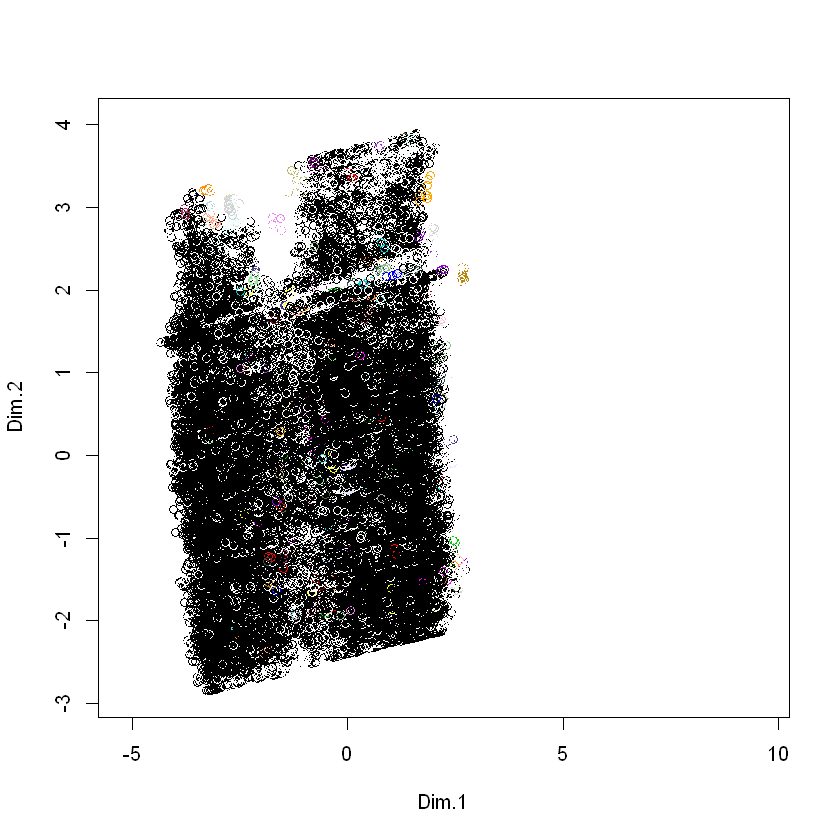

In [66]:
plot(res_pca2$ind$coord, col = db$cluster)

### CAH mixte (ACP -> Kmeans -> CAH)

idée : on réalise un pré-regroupement des individus via kmeans. <br/>
Le préregroupement est le point de départ de la création du dendrogramme de la CAH.
Nous utilisons un nombre de classes important par kmeans, dans lequel sur de l'homogénéité des individus. <br/>
Cela permet de réduire la quantité d'individus qui passera de 183928 au nombre de clusters
afin de ne pas perdre la possibilité d'interpréter, nous relancons ensuite une ACP pondérée par le nombre d'individus de chaque classe

In [67]:
set.seed(123)
obj_kmeans <- kmeans(res_pca2$ind$coord, centers = 100, nstart = 10, iter.max = 40) 

Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"

* nstart : execution de plusieurs segmentation en gardant la meilleure
+ iter.max : le nombre d'itération maximale pour que l'algo converge

In [69]:
print(obj_kmeans) 

K-means clustering with 100 clusters of sizes 3721, 864, 871, 2620, 3073, 1772, 799, 1617, 387, 3881, 978, 1934, 2322, 2304, 2561, 990, 1170, 741, 944, 2415, 522, 1063, 3635, 3298, 3205, 1255, 803, 1774, 3040, 2259, 2499, 1183, 3117, 2120, 1935, 513, 3889, 778, 2915, 1608, 2531, 3244, 3219, 1934, 610, 2548, 875, 1461, 2838, 1461, 1781, 890, 4373, 2073, 2667, 862, 1815, 451, 3007, 3144, 3683, 612, 1677, 3412, 770, 1639, 614, 1544, 620, 1309, 2161, 1294, 980, 700, 1275, 1056, 1741, 39, 162, 1097, 3063, 1595, 3226, 1225, 2263, 334, 1382, 979, 1386, 3249, 2058, 1735, 2098, 4019, 350, 2451, 2207, 554, 2528, 1682

Cluster means:
          Dim.1      Dim.2        Dim.3        Dim.4
1    0.61348408  0.5006266  0.457563713 -0.304825170
2   -0.76719606 -1.5109050 -1.695494275 -0.440502988
3   -1.02457753  1.6442264 -0.736230805 -0.312335855
4   -0.20555609  1.9056069  0.981160384 -0.029109510
5    0.28834986  1.1051563  0.757016788 -0.202130992
6   -3.10835742 -1.9433030  0.110197859  0.13677225

(between_SS / total_SS =  93.0 %) == proportion d'intertie expliquée par la partition avec 100

In [70]:
obj_kmeans$iter # donne le nombre d'iteration utilisees pour converger (si convergence)

[1] 26

In [71]:
obj_kmeans_df <- cbind.data.frame(obj_kmeans$size,obj_kmeans$centers)
colnames(obj_kmeans_df)[1] <- "effectifs_classe"

In [72]:
# on réalise de nouveau une acp en prenant bien soin de ne pas centrer réduire et de conserver toutes les composantes
res_pca3 <- PCA(obj_kmeans_df[,2:5],row.w = obj_kmeans_df[,1],scale.unit = FALSE, ncp = Inf)

A partir du centre des classes et des effectifs on réalise un arbre hiérarchique. <br/>
L'arbre correspond ainsi au haut de l'arbre hiérarchique que l'on aurait obtenu à partir de tous les individus (le bas est perdu mais seul le haut de l'arbre est utile pour l'interprétation métier)

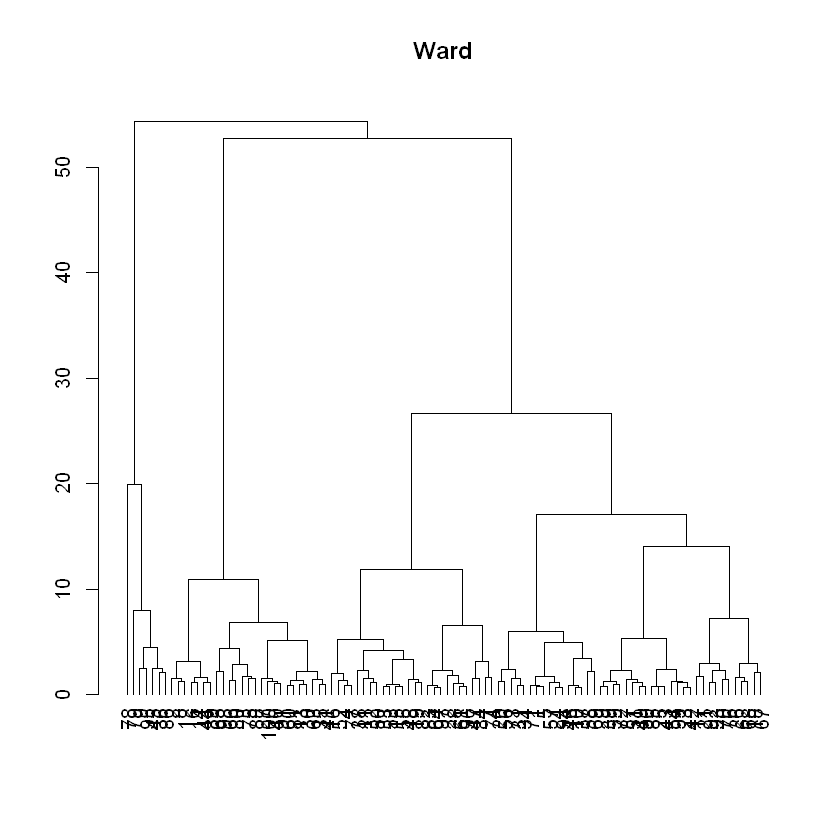

In [83]:
dist <- dist(res_pca3$ind$coord,method="euclidean")
cah <- fastcluster::hclust(dist,method="ward.D")
plot(as.dendrogram(cah),main="Ward")
#res_hcpc <- HCPC(res_pca3$ind$coord,graph=TRUE, order = FALSE, iter.max = 20) # IMPORTANT: order=FALSE pour conserver l'ordre des individus dans le fichier
# attentionbuggé avec la fonction HCPC de factominer qui déconne cf internet

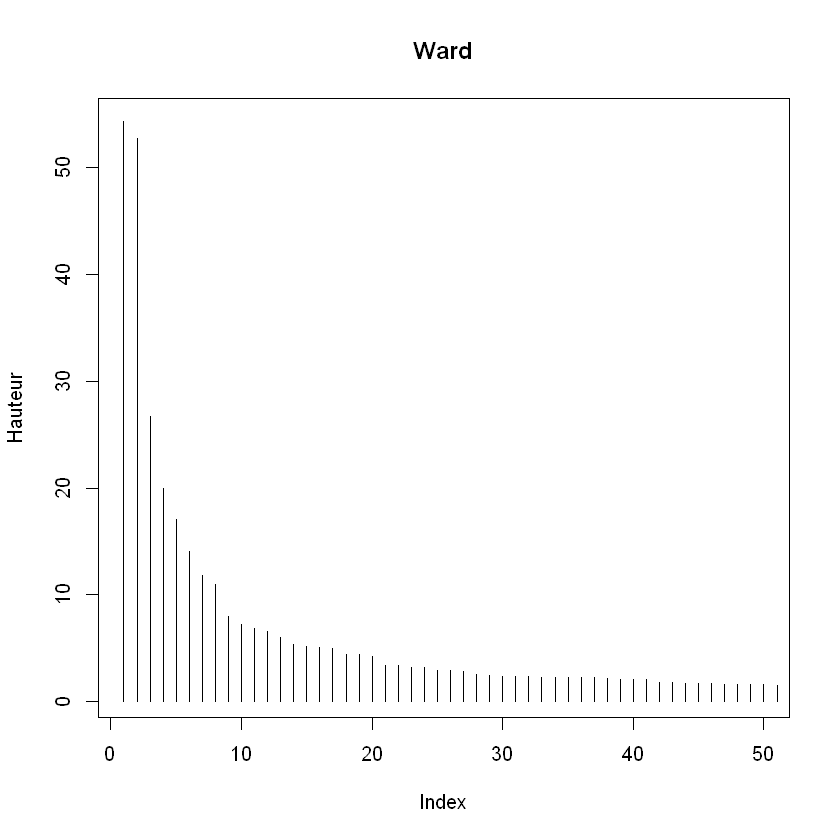

In [84]:
plot(sort(cah$height,decreasing=TRUE),type="h",xlim=c(1,50),ylab="Hauteur",main="Ward")

La rupture n'est nette. 8 Clusters semblent un bon compromis

In [85]:
# Kmeans sur les 4 premières composantes principales (donc clustering sur la base des variables qualitatives)
# Avec le nombre de clusters optimal
groupe_kmeans <- kmeans (res_pca3$ind$coord, centers = 8, nstart = 10, iter.max = 100) 

### Kmeans et CAH (sans ACP)

idée : on réalise un pré-regroupement des individus via kmeans. <br/>
On réduit donc le nombre d'invidus par des représentants <br/>
On applique ensuite une classification ascendante hiérarchique pour trouver le nombre de clusters optimal <br/>
Enfin, on pourra appliquer un nouveau kmeans avec ce nombre optimal.

In [75]:
set.seed(123)
obj_kmeans <- kmeans(scale(varquanti3), centers = 2000, nstart = 20, iter.max = 100) 

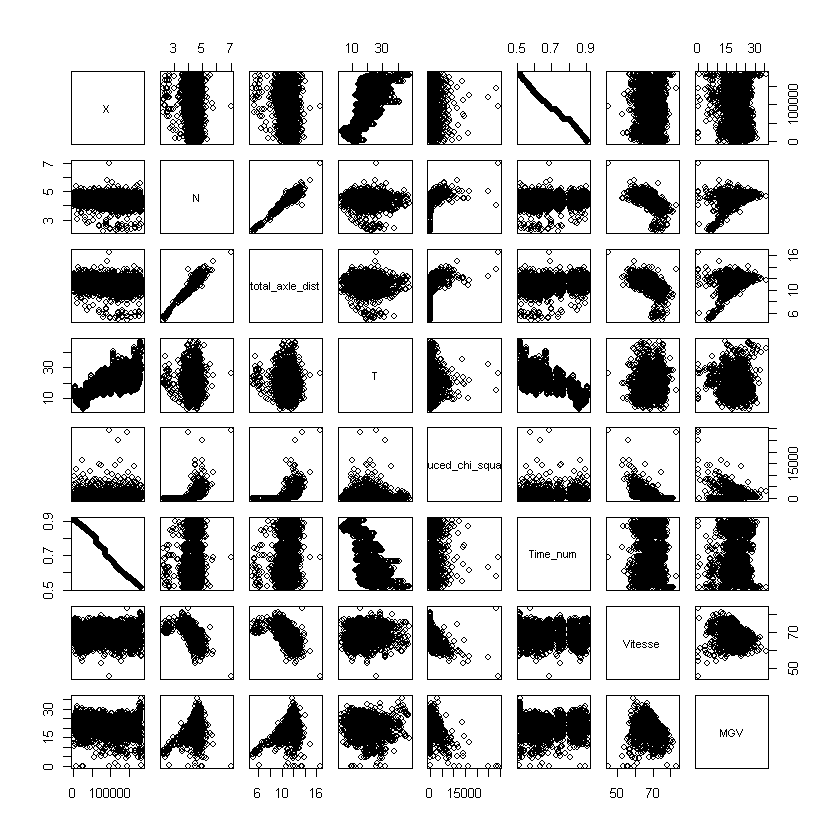

In [77]:
pairs(obj_kmeans$centers)

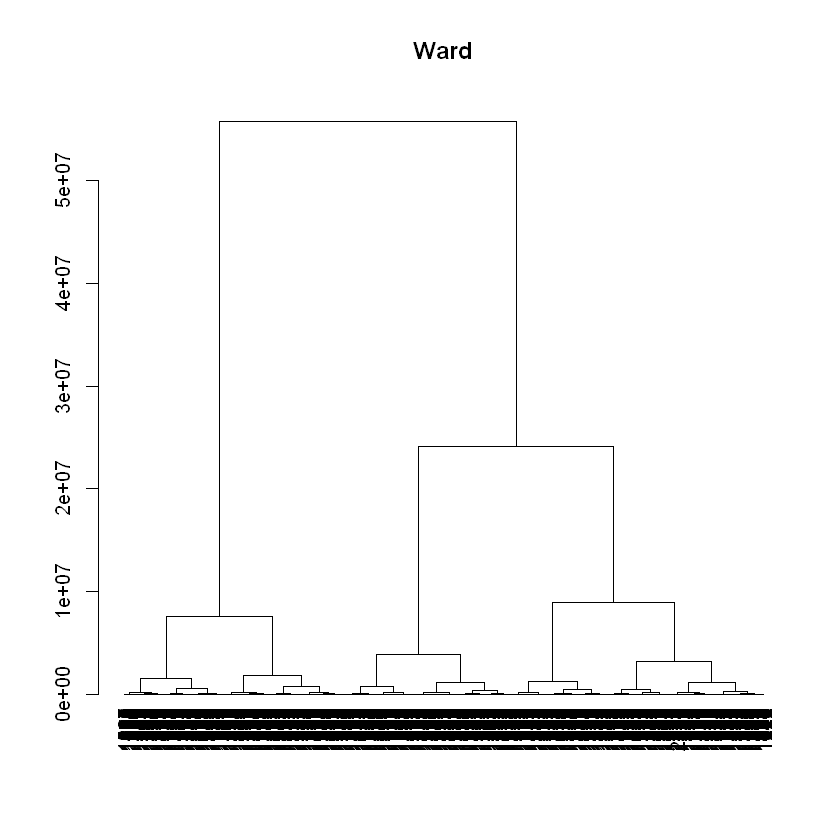

In [80]:
dist <- dist(obj_kmeans$centers,method="euclidean")
cah <- fastcluster::hclust(dist,method="ward.D")
plot(as.dendrogram(cah),main="Ward")

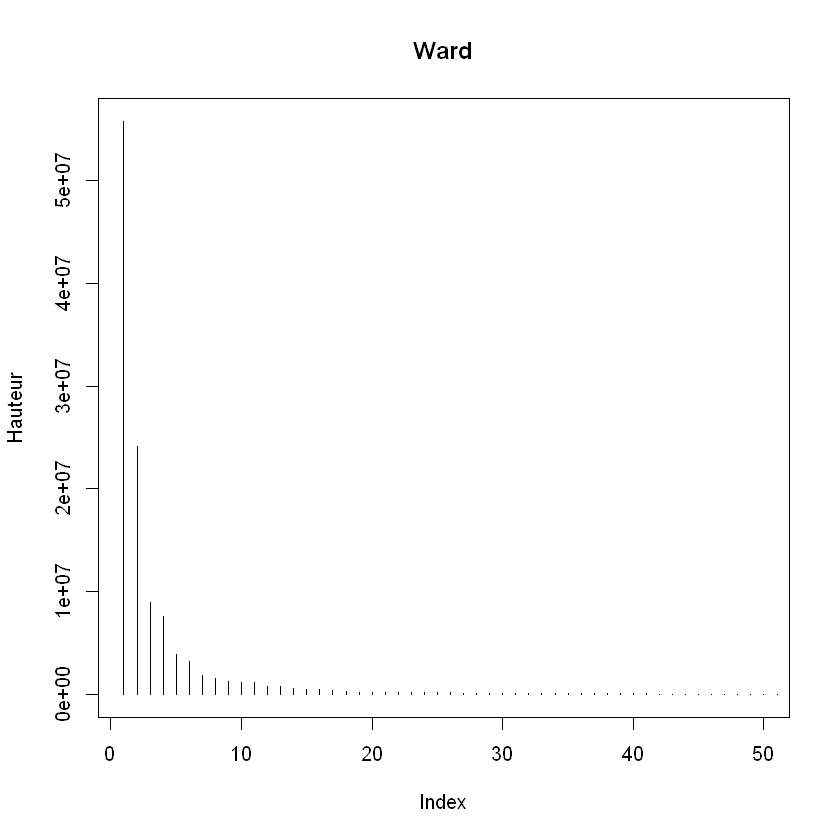

In [81]:
plot(sort(cah$height,decreasing=TRUE),type="h",xlim=c(1,50),ylab="Hauteur",main="Ward")

La rupture a lieu pour k = 4

In [82]:
km2 <- kmeans(varquanti3, centers = 4, nstart = 20, iter.max = 100) 

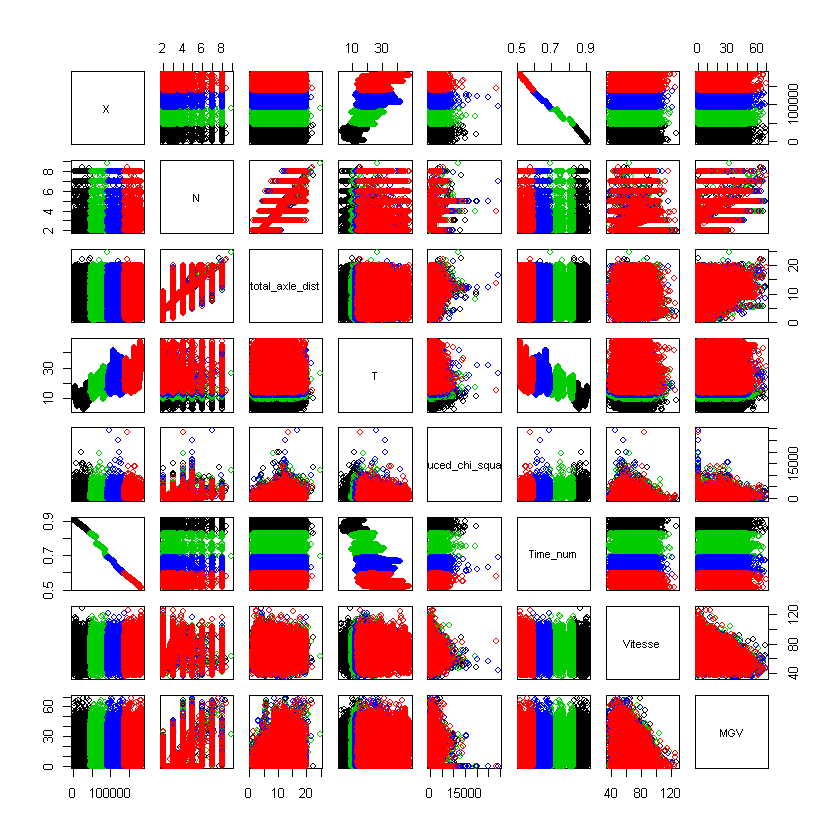

In [91]:
pairs(varquanti3, col = km2$cluster)

A priori la découpe via Kmeans ressemble à une découpe temporelle

### Kmeans only

L'algorithme de kmeans nécessite de fixer à priori le nombre de classes, et l'initialisation au hasard peut donner des résultats assez variables. <br/>
Nous pouvons faire varier le nombre de classes et observer le résultat, en optimisant le rapport d'inertie. <br/>
Nous pouvons lancer Kmeans sur un grand nombre de classes (ex 100) chaque classe 


In [87]:
# evaluation de la proportion expliquée
inertie_expl <- rep(0,times=10)
for (k in 2:10){
  clus <-kmeans(res_pca2$ind$coord, centers = k, nstart = 10, iter.max = 40)
  inertie_expl[k] <- clus$betweenss / clus$totss
} 

Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"

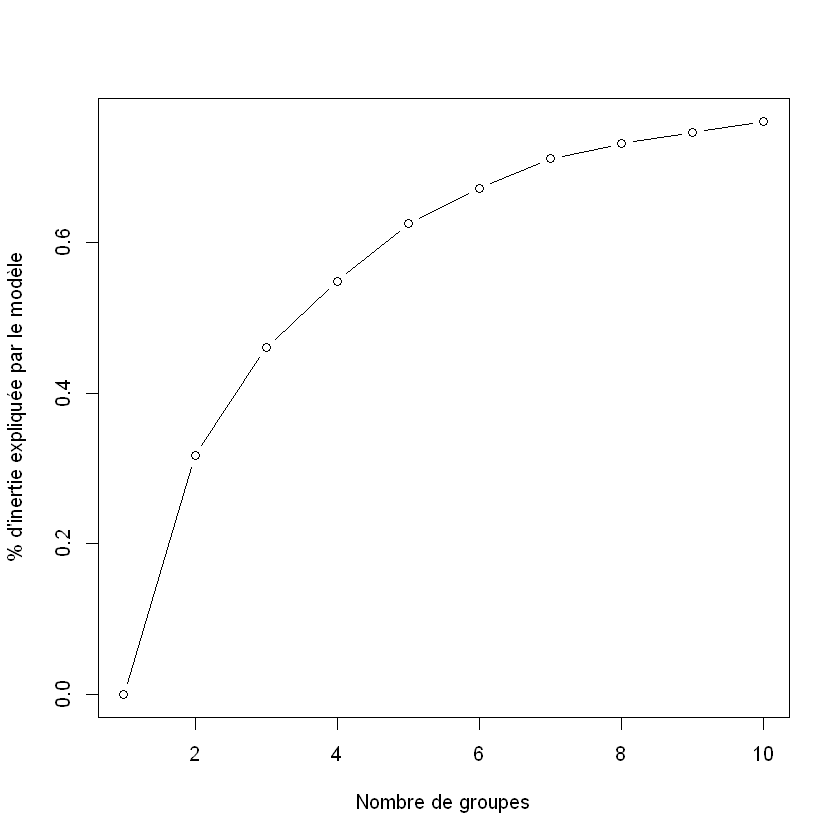

In [88]:
plot(1:10,inertie_expl, type = "b", xlab = "Nombre de groupes", ylab = "% d'inertie expliquée par le modèle" )

A partir de 4 classes le rajout d'un groupe supplémentaire n'augmente pas significativement la part d'inertie expliquée par la partition

#### 2ème methode - indice de Calinski Harabasz - utilisation du package fpc

In [89]:
# evaluation des solutions
sol_kmeans <- kmeansruns(res_pca2$ind$coord,krange = 2:10, criterion = "ch")

Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage steps exceeded maximum (= 9196400)"Warning message:
"Quick-TRANSfer stage

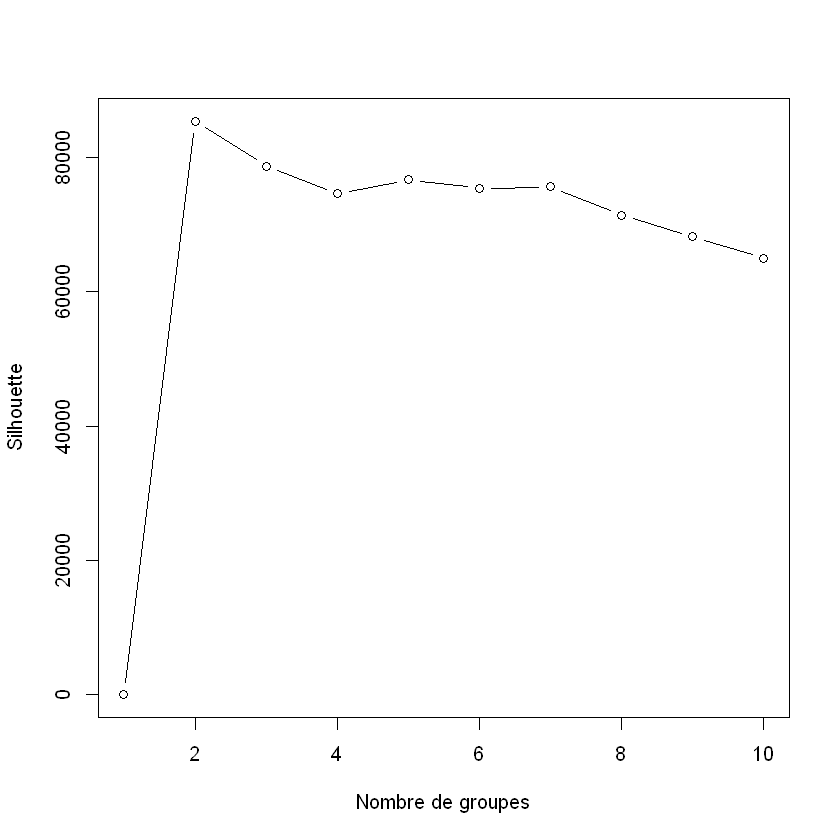

In [90]:
# graphique 
plot(1:10, sol_kmeans$crit,type = "b", xlab = "Nombre de groupes", ylab = "Silhouette")

La solution à 2 classes maximise ici le critère 

liens web sur factominer et CAH mixte :
* HCPC : http://forums.cirad.fr/logiciel-R/viewtopic.php?t=3132
+ HCPC : https://groups.google.com/forum/#!topic/factominer-users/lnCW9DAE5z0
+ CAH mixte : http://chirouble.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_CAH_Mixte_Gros_Volumes.pdf
+ kmeans : https://eric.univ-lyon2.fr/~ricco/cours/didacticiels/R/cah_kmeans_avec_r.pdf